In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
# import sqlite3
# from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, normalized_mutual_info_score

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold, cross_val_score
import math
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Machine Learning Models


In [10]:
data = pd.read_csv('final_features.csv', encoding='latin-1', nrows=20001)
data.head(3)

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,89.509871,-110.533625,-100.479424,90.664803,19.507948,-15.140525,-19.345136,-129.408695,-118.284831,89.844395
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,81.915579,52.010940,91.056819,-0.052428,-165.972075,103.077540,-83.073252,-68.480301,-117.666431,173.873648
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,88.559925,19.308219,128.521377,126.306732,-44.066754,148.308988,152.486339,-244.803431,2.997449,250.107358


In [11]:
data.shape

(20001, 629)

## Random Train-Test Split (70:30)

In [12]:
# removing the class and dropping
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [13]:
data.head(3)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,89.509871,-110.533625,-100.479424,90.664803,19.507948,-15.140525,-19.345136,-129.408695,-118.284831,89.844395
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,81.915579,52.010940,91.056819,-0.052428,-165.972075,103.077540,-83.073252,-68.480301,-117.666431,173.873648
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,88.559925,19.308219,128.521377,126.306732,-44.066754,148.308988,152.486339,-244.803431,2.997449,250.107358


In [14]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [15]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (14000, 626)
Number of data points in test data : (6001, 626)


In [16]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6262857142857143 Class 1:  0.3737142857142857
---------- Distribution of output variable in train data ----------
Class 0:  0.6263956007332111 Class 1:  0.37360439926678884


#### functions for confusion matrix:

In [17]:
def plot_confusion_matrix(test_y, pred_y):
    C = confusion_matrix(test_y, pred_y)
    
    A =(((C.T)/(C.sum(axis=1))).T) #taking traspose and adding rows wise
    B =(C/C.sum(axis=0)) # adding cl=olumns wise
    
    plt.figure(figsize=(15,5))
    labels = [1,2]
    
    # representing A in heat-map
    cmap = sns.light_palette("red")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted class")
    plt.ylabel("Original class")
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building a random model and finding the worst-case log_loss

log_loss on test data using random model 0.8782785230351072


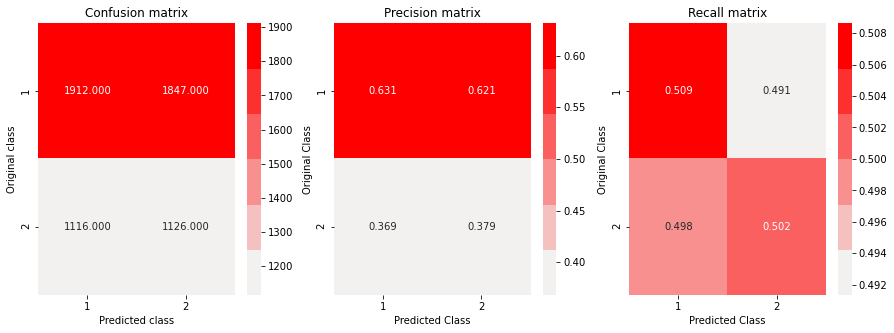

In [18]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("log_loss on test data using random model", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with hyperparameter tuning:


For values of alpha=  1e-05 The log_loss is : 0.6602837391666504
For values of alpha=  0.0001 The log_loss is : 0.47286256352966316
For values of alpha=  0.001 The log_loss is : 0.46184100911092385
For values of alpha=  0.01 The log_loss is : 0.4667847331251597
For values of alpha=  0.1 The log_loss is : 0.4640619266807957
For values of alpha=  1 The log_loss is : 0.47340772010642135
For values of alpha=  10 The log_loss is : 0.5080992704779539


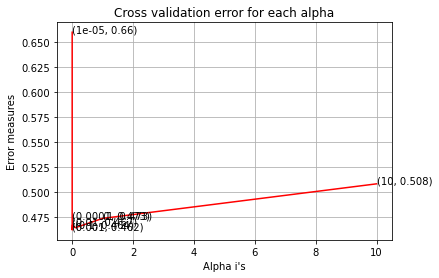

for values of best alpha= 0.001 The train log loss is  0.46022195522558657
for values of best alpha= 0.001 The test log loss is  0.46184100911092385
Total number of data points : 30001


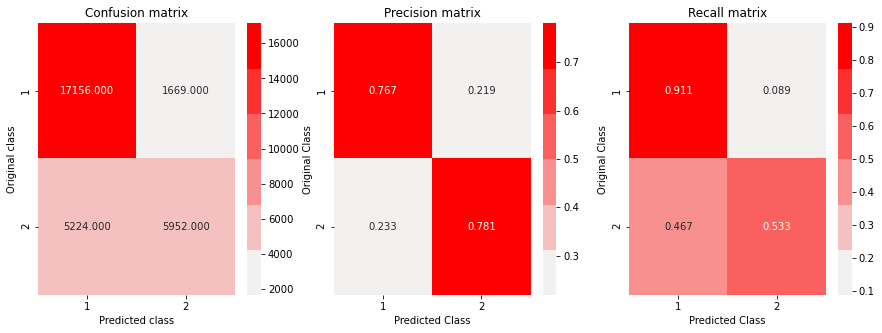

In [12]:
## read more about SGDClassifier() at 
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

alpha = [10**x for x in range(-5,2)] # hyper-parameter
log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i,penalty='l2', loss='log', random_state=42)
    clf.fit(X_train,y_train)
    
    # use calibration
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print("For values of alpha= ",i, "The log_loss is :",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='r')
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], log_error_array[i]))
plt.grid()
plt.title("Cross validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measures")
plt.show()

# building classifier for best alpha

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print("for values of best alpha=", alpha[best_alpha], "The train log loss is ", log_loss(y_train, predict_y, labels=clf.classes_,eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print("for values of best alpha=", alpha[best_alpha], "The test log loss is ", log_loss(y_test, predict_y, labels=clf.classes_,eps=1e-15))

predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM using hyperparameter tuning:

For values of alpha =  1e-05 The log loss is: 0.6608462578487653
For values of alpha =  0.0001 The log loss is: 0.6608462578487653
For values of alpha =  0.001 The log loss is: 0.6608462578487653
For values of alpha =  0.01 The log loss is: 0.6608462578487653
For values of alpha =  0.1 The log loss is: 0.6608462578487653
For values of alpha =  1 The log loss is: 0.6608462578487653
For values of alpha =  10 The log loss is: 0.6608462578487653


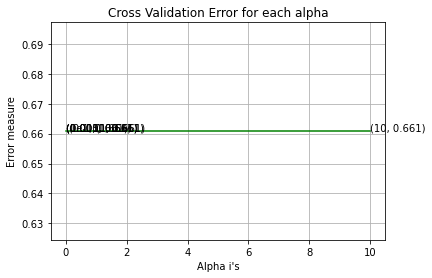

For values of best alpha =  1e-05 The train log loss is: 0.660902951564485
For values of best alpha =  1e-05 The test log loss is: 0.6608462578487653
Total number of data points : 6001


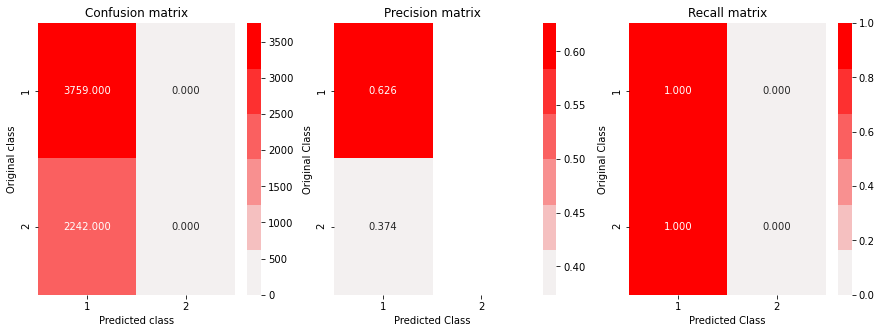

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


# XGBoost

In [21]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


[0]	train-logloss:0.68487	valid-logloss:0.68521
[10]	train-logloss:0.61631	valid-logloss:0.61985
[20]	train-logloss:0.56628	valid-logloss:0.57175
[30]	train-logloss:0.52764	valid-logloss:0.53455
[40]	train-logloss:0.49826	valid-logloss:0.50589
[50]	train-logloss:0.47487	valid-logloss:0.48336
[60]	train-logloss:0.45624	valid-logloss:0.46563
[70]	train-logloss:0.44100	valid-logloss:0.45124
[80]	train-logloss:0.42843	valid-logloss:0.43936
[90]	train-logloss:0.41796	valid-logloss:0.42953
[100]	train-logloss:0.40939	valid-logloss:0.42164
[110]	train-logloss:0.40200	valid-logloss:0.41481
[120]	train-logloss:0.39547	valid-logloss:0.40899
[130]	train-logloss:0.38979	valid-logloss:0.40420
[140]	train-logloss:0.38486	valid-logloss:0.40041
[150]	train-logloss:0.38027	valid-logloss:0.39685
[160]	train-logloss:0.37632	valid-logloss:0.39370
[170]	train-logloss:0.37270	valid-logloss:0.39108
[180]	train-logloss:0.36929	valid-logloss:0.38879
[190]	train-logloss:0.36600	valid-logloss:0.38657
[200]	train

Total number of data points : 6001


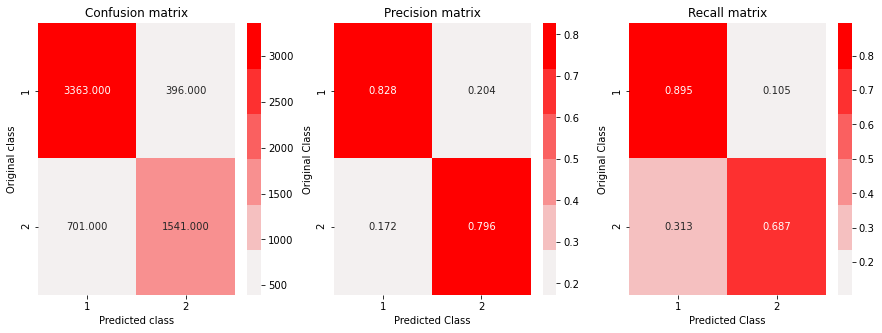

In [22]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [23]:
# out of the these three models, xgboost perform best